# Ensemble of the best models: kemans, ward, clara

Try kmeans + ward; kmeans + clara; ward + clara; kmeans + ward + clara 

In [313]:
import pandas as pd
from sklearn.cluster import KMeans,  AgglomerativeClustering
from sklearn_extra.cluster import CLARA
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import pairwise_distances

In [314]:
df = pd.read_csv('../2_models/with_raw_data/solar/df_scaled.csv')
pca_df = pd.read_csv('../2_models/with_raw_data/solar/pca_df.csv')
subset_df = pd.read_csv('../2_models/with_raw_data/solar/df_subset.csv')

In [315]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

## K-Means + Ward Link

In [316]:
# K-Means:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

KMeans is done


In [318]:
# Gaussian Mixture:
ward = AgglomerativeClustering(linkage='ward', distance_threshold=0.01, n_clusters=None)
ward.fit(np.array(df))

# Cut dendrogram to obtain labels
num_clusters = 5  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([ward.children_, ward.distances_,
                                  np.ones_like(ward.distances_)])
# Cut the tree to obtain labels
ward_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

In [319]:
ward_labels -= 1

In [320]:
with open('results/raw_solar/ward.pickle', 'wb') as f:
    pickle.dump(ward_labels, f)
    

with open('results/raw_solar/kmeans.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [321]:
with open('results/raw_solar/ward.pickle', 'rb') as f:
   ward_labels = pickle.load(f)

with open('results/raw_solar/kmeans.pickle', 'rb') as f:
   kmeans = pickle.load(f)

kmeans_labels = kmeans.fit_predict(df)

Using Weighted Major Voting as Ensemble Technique

In [322]:
high_weight = 2
avg_weight = 1.5
low_weight = 1

In [323]:
# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(ward_labels)))
voting_labels_kmeans_ward = np.zeros(len(df), dtype=float)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    ward_cluster = ward_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=float)
    votes[kmeans_cluster] += 1*high_weight
    votes[ward_cluster] += 1*avg_weight
    
    # Assign the data point to the cluster with the most votes
    voting_labels_kmeans_ward[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [324]:
df['cluster_label'] = voting_labels_kmeans_ward
df['asset_id'] = subset_df['asset_id']

pca_df['cluster_label'] = voting_labels_kmeans_ward

In [325]:
df.to_csv('results/raw_solar/ward_kmeans.csv', index = False)

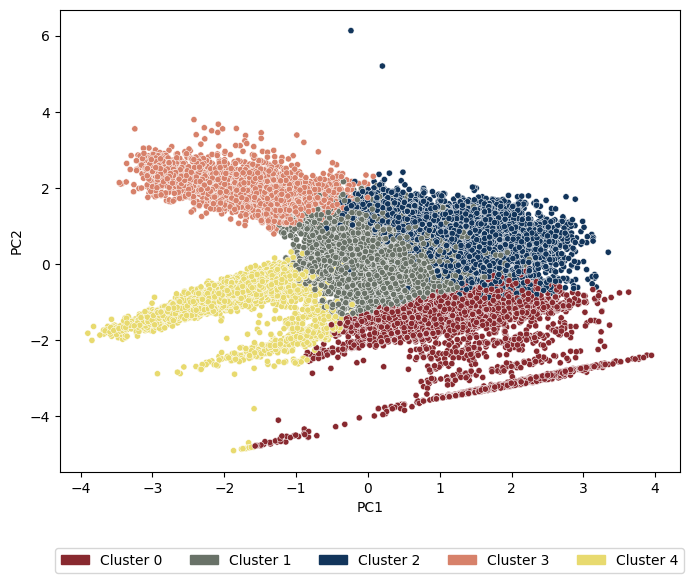

In [327]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_kmeans_ward).astype(int)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [328]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,0,1,2,3,4,asset_id,cluster_label
0,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,11,0
1,-0.469440,-0.605656,-1.540451,0.408095,-0.780179,11,0
2,-0.462222,-0.566264,-1.417633,-0.185869,0.300288,11,0
3,-0.499687,-0.826978,-1.690806,-0.360564,1.902361,11,0
4,-0.211838,1.313884,-1.545407,-1.059346,-0.705664,11,0


In [329]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,0,1,2,3,4,cluster_label
0,11,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,0
1,12,-0.505775,-0.870976,-2.118668,-2.229804,-0.780179,0
2,13,0.005922,1.294854,0.568233,-0.884650,-0.780179,4
3,14,-0.496468,-0.836917,-0.064743,-0.360564,0.188516,4
4,15,0.022537,1.425999,0.439837,-1.408736,-0.780179,4
...,...,...,...,...,...,...,...
72,510,-0.406867,-0.875339,0.179751,-0.011174,-0.780179,3
73,511,-0.493762,-0.891702,0.029674,-0.360564,-0.109544,3
74,512,-0.508328,-0.894854,-4.365336,-1.758127,-0.444862,3
75,513,4.141960,-0.035564,0.350060,0.687608,-0.780179,3


In [330]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 52, 58]
Cluster 1: [9, 10, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 46, 48, 49, 50, 51, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [37, 38, 40]
Cluster 3: [36, 39, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 47, 54]


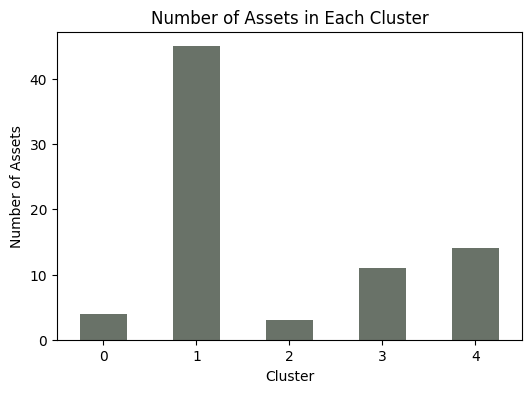

In [331]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [332]:
def dunn_index(points = np.array(df), labels = voting_labels_kmeans_ward):
    min_intercluster_distances = []
    max_intracluster_distances = []
    
    for label in np.unique(labels):
        cluster_points = points[labels == label]
        if len(cluster_points) > 1:
            intracluster_distances = pairwise_distances(cluster_points)
            max_intracluster_distances.append(np.max(intracluster_distances))
        
        for other_label in np.unique(labels):
            if label != other_label:
                other_cluster_points = points[labels == other_label]
                intercluster_distances = pairwise_distances(cluster_points, other_cluster_points)
                min_intercluster_distances.append(np.min(intercluster_distances))
    
    if len(max_intracluster_distances) == 0 or len(min_intercluster_distances) == 0:
        return 0
    
    return min(min_intercluster_distances) / max(max_intracluster_distances)


In [333]:
def xie_beni_index(points = np.array(df), labels = voting_labels_kmeans_ward):
    # Compute the total scatter
    total_scatter = np.sum(pairwise_distances(points) ** 2) / (2 * len(points))
    
    # Compute the intra-cluster scatter
    cluster_labels = np.unique(labels)
    intra_cluster_scatter = 0
    for label in cluster_labels:
        cluster_points = points[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        intra_cluster_scatter += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
    intra_cluster_scatter /= len(points)
    
    return intra_cluster_scatter / total_scatter


In [334]:
# Define a function to compute evaluation metrics
def compute_metrics(points = np.array(df[['0', '1', '2', '3', '4']]), labels = voting_labels_kmeans_ward):

    metrics = {}
    
    metrics['Silhouette Score'] = silhouette_score(points, labels)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(points, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(points, labels)
    metrics['Dunn Index'] = dunn_index(points, labels)
    metrics['Xie-Beni Index'] = xie_beni_index(points, labels)

    return metrics


In [335]:
np.unique(voting_labels_kmeans_ward)

array([0., 1., 2., 3., 4.])

In [336]:
# Initialize an empty list to store the results
results = []

# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_kmeans_ward)
results.append({'Model': 'ward + kmeans_opt', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [337]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,ward + kmeans_opt,0.328741,1.004836,17873.52754,0.001309,0.000009


## K-Means + Clara with optimized parameters

In [338]:
df = df[['0', '1', '2', '3', '4']]
pca_df = pca_df[['PC1', 'PC2']]

In [339]:
# K-Means:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

clara = CLARA(n_clusters=5, random_state=1)
clara_labels = clara.fit_predict(df)

KMeans is done


In [340]:
with open('results/raw_solar/clara.pickle', "wb") as f:
    pickle.dump(clara, f)

In [341]:
with open('results/raw_solar/clara.pickle', "rb") as f:
    clara = pickle.load(f)
clara_labels = clara.fit_predict(df)

In [342]:
# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(clara_labels)))
voting_labels_kmeans_clara = np.zeros(len(df), dtype=float)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=float)
    votes[kmeans_cluster] += 1*high_weight
    votes[clara_cluster] += 1*low_weight
    
    # Assign the data point to the cluster with the most votes
    voting_labels_kmeans_clara[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [343]:
pca_df = pca_df[['PC1', 'PC2']]

In [344]:
df['cluster_label'] = voting_labels_kmeans_clara

pca_df['cluster_label'] = voting_labels_kmeans_clara

df['asset_id'] = subset_df['asset_id']

In [345]:
df.to_csv('results/raw_solar/clara_kmeans.csv', index = False)

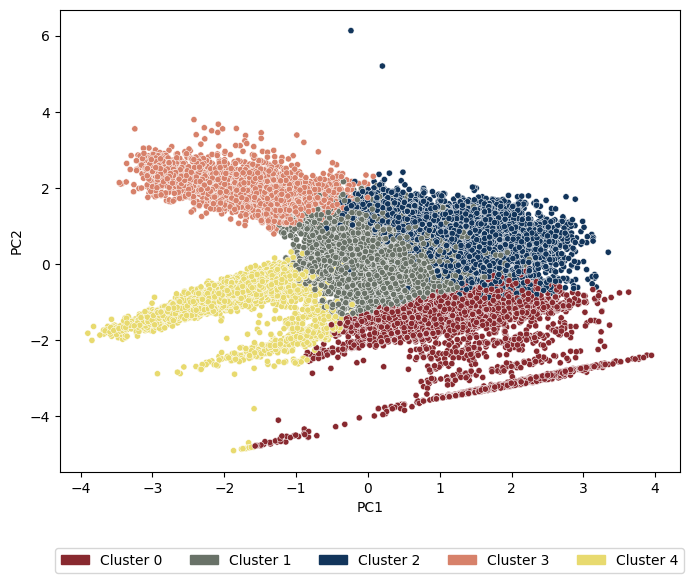

In [347]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means and CLARA')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_kmeans_clara).astype(int)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [348]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,0,1,2,3,4,asset_id,cluster_label
0,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,11,0
1,-0.469440,-0.605656,-1.540451,0.408095,-0.780179,11,0
2,-0.462222,-0.566264,-1.417633,-0.185869,0.300288,11,0
3,-0.499687,-0.826978,-1.690806,-0.360564,1.902361,11,0
4,-0.211838,1.313884,-1.545407,-1.059346,-0.705664,11,0


In [349]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,0,1,2,3,4,cluster_label
0,11,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,0
1,12,-0.505775,-0.870976,-2.118668,-2.229804,-0.780179,0
2,13,0.005922,1.294854,0.568233,-0.884650,-0.780179,4
3,14,-0.496468,-0.836917,-0.064743,-0.360564,0.188516,4
4,15,0.022537,1.425999,0.439837,-1.408736,-0.780179,4
...,...,...,...,...,...,...,...
72,510,-0.406867,-0.875339,0.179751,-0.011174,-0.780179,3
73,511,-0.493762,-0.891702,0.029674,-0.360564,-0.109544,3
74,512,-0.508328,-0.894854,-4.365336,-1.758127,-0.444862,3
75,513,4.141960,-0.035564,0.350060,0.687608,-0.780179,3


In [350]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 52, 58]
Cluster 1: [9, 10, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 46, 48, 49, 50, 51, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [37, 38, 40]
Cluster 3: [36, 39, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 47, 54]


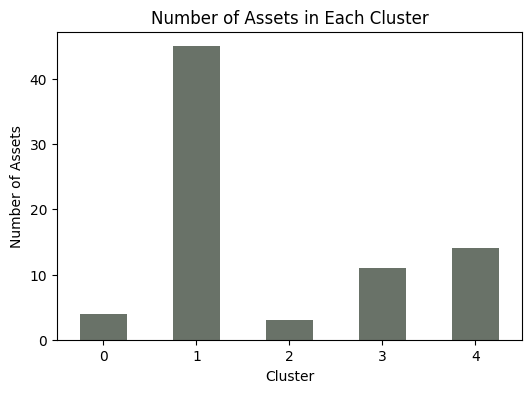

In [351]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [352]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_kmeans_clara)
results.append({'Model': 'clara + kmeans', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [353]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,ward + kmeans_opt,0.328741,1.004836,17873.52754,0.001309,0.000009
1,clara + kmeans,0.328741,1.004836,17873.52754,0.001309,0.000009


## Ward + CLARA

In [354]:
df = df[['0', '1', '2', '3', '4']]
pca_df = pca_df[['PC1', 'PC2']]

In [355]:
# Voting based on cluster assignments
num_clusters = max(len(set(ward_labels)), len(set(clara_labels)))
voting_labels_ward_clara = np.zeros(len(df), dtype=float)

for i in range(len(df)):
    ward_cluster = ward_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=float)
    votes[ward_cluster] += 1*avg_weight
    votes[clara_cluster] += 1*low_weight
    
    # Assign the data point to the cluster with the most votes
    voting_labels_ward_clara[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [356]:
df['cluster_label'] = voting_labels_ward_clara
df['asset_id'] = subset_df['asset_id']
pca_df['cluster_label'] = voting_labels_ward_clara

In [357]:
df.to_csv('results/raw_solar/ward_clara.csv', index = False)

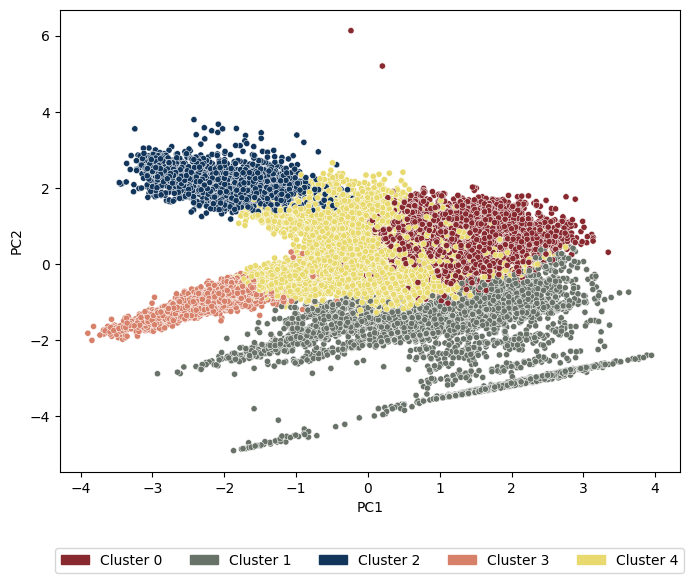

In [359]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title("Ensemble CLARA and Ward's Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_ward_clara).astype(int)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [360]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,0,1,2,3,4,asset_id,cluster_label
0,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,11,1
1,-0.469440,-0.605656,-1.540451,0.408095,-0.780179,11,1
2,-0.462222,-0.566264,-1.417633,-0.185869,0.300288,11,1
3,-0.499687,-0.826978,-1.690806,-0.360564,1.902361,11,1
4,-0.211838,1.313884,-1.545407,-1.059346,-0.705664,11,1


In [361]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,0,1,2,3,4,cluster_label
0,11,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,1
1,12,-0.505775,-0.870976,-2.118668,-2.229804,-0.780179,1
2,13,0.005922,1.294854,0.568233,-0.884650,-0.780179,4
3,14,-0.496468,-0.836917,-0.064743,-0.360564,0.188516,4
4,15,0.022537,1.425999,0.439837,-1.408736,-0.780179,4
...,...,...,...,...,...,...,...
72,510,-0.406867,-0.875339,0.179751,-0.011174,-0.780179,4
73,511,-0.493762,-0.891702,0.029674,-0.360564,-0.109544,4
74,512,-0.508328,-0.894854,-4.365336,-1.758127,-0.444862,2
75,513,4.141960,-0.035564,0.350060,0.687608,-0.780179,2


In [362]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [37, 40]
Cluster 1: [0, 1, 23, 33, 52, 58]
Cluster 2: [74, 75]
Cluster 4: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76]


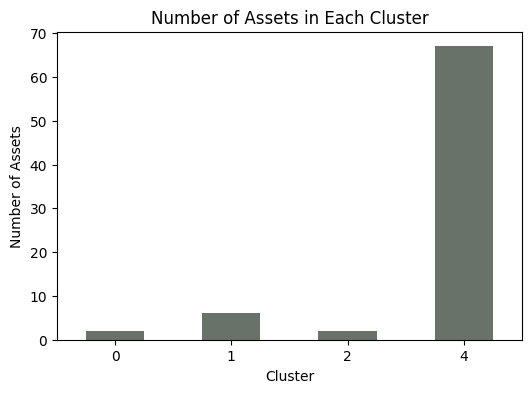

In [363]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [364]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_ward_clara)
results.append({'Model': 'ward + clara', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [365]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,ward + kmeans_opt,0.328741,1.004836,17873.527540,0.001309,0.000009
1,clara + kmeans,0.328741,1.004836,17873.527540,0.001309,0.000009
2,ward + clara,0.257280,1.099358,13809.903607,0.004169,0.000010


## ward + K-Means + CLARA

In [366]:
df = df[['0', '1', '2', '3', '4']]

pca_df = pca_df[['PC1', 'PC2']]

In [367]:
voting_labels_all = np.zeros(len(df), dtype=float)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    ward_cluster = ward_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=float)
    votes[kmeans_cluster] += 1*high_weight
    votes[ward_cluster] += 1*avg_weight
    votes[clara_cluster] += 1*low_weight
    
    # Assign the data point to the cluster with the most votes
    voting_labels_all[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [368]:
df['cluster_label'] = voting_labels_all
df['asset_id'] = subset_df['asset_id']

pca_df['cluster_label'] = voting_labels_all

In [369]:
df.to_csv('results/raw_solar/clara_kmeans_ward.csv', index = False)

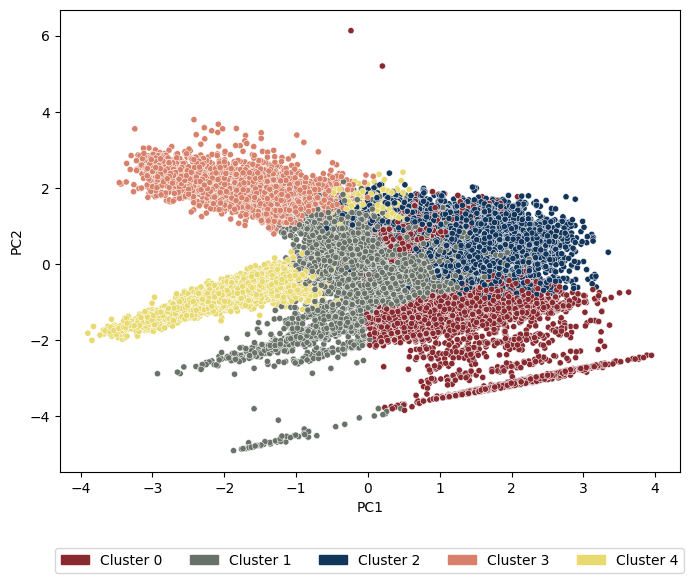

In [370]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means, CLARA and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_all).astype(int)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [371]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,0,1,2,3,4,asset_id,cluster_label
0,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,11,0
1,-0.469440,-0.605656,-1.540451,0.408095,-0.780179,11,0
2,-0.462222,-0.566264,-1.417633,-0.185869,0.300288,11,0
3,-0.499687,-0.826978,-1.690806,-0.360564,1.902361,11,0
4,-0.211838,1.313884,-1.545407,-1.059346,-0.705664,11,0


In [372]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,0,1,2,3,4,cluster_label
0,11,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,0
1,12,-0.505775,-0.870976,-2.118668,-2.229804,-0.780179,0
2,13,0.005922,1.294854,0.568233,-0.884650,-0.780179,4
3,14,-0.496468,-0.836917,-0.064743,-0.360564,0.188516,4
4,15,0.022537,1.425999,0.439837,-1.408736,-0.780179,4
...,...,...,...,...,...,...,...
72,510,-0.406867,-0.875339,0.179751,-0.011174,-0.780179,3
73,511,-0.493762,-0.891702,0.029674,-0.360564,-0.109544,3
74,512,-0.508328,-0.894854,-4.365336,-1.758127,-0.444862,3
75,513,4.141960,-0.035564,0.350060,0.687608,-0.780179,3


In [373]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 52, 58]
Cluster 1: [9, 10, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 48, 49, 50, 51, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 3: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 46, 47, 54]


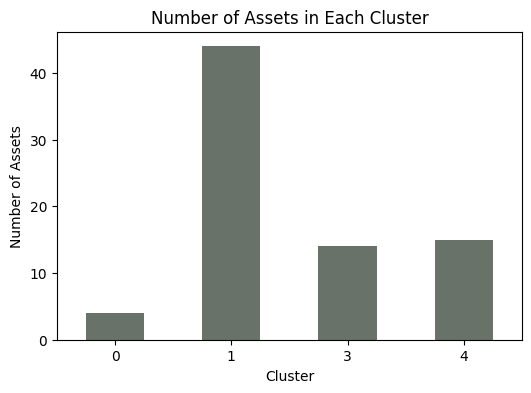

In [374]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [375]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_all)
results.append({'Model': 'clara + kmeans + ward', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [376]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,ward + kmeans_opt,0.328741,1.004836,17873.527540,0.001309,0.000009
1,clara + kmeans,0.328741,1.004836,17873.527540,0.001309,0.000009
2,ward + clara,0.257280,1.099358,13809.903607,0.004169,0.000010
3,clara + kmeans + ward,0.262114,1.502345,12091.450663,0.001031,0.000011


In [377]:
with open('results/raw_solar/results.pickle', 'wb') as f:
    pickle.dump(results,f)

results_df.to_csv('results/raw_solar/results.csv', index=False)

In [378]:
normalized_df = results_df.copy()

# Define ideal and anti-ideal solutions for each metric
ideal_solution = normalized_df.copy()
anti_ideal_solution = normalized_df.copy()

# Define metrics where higher values are better
higher_is_better = ['Silhouette Score', 'Dunn Index', 'Calinski-Harabasz Index']

# Define metrics where lower values are better
lower_is_better = ['Davies-Bouldin Index', 'Xie-Beni Index']

# Set ideal and anti-ideal solutions for metrics where higher values are better
for metric in higher_is_better:
    ideal_solution[metric] = normalized_df[metric].max()
    anti_ideal_solution[metric] = normalized_df[metric].min()

# Set ideal and anti-ideal solutions for metrics where lower values are better
for metric in lower_is_better:
    ideal_solution[metric] = normalized_df[metric].min()
    anti_ideal_solution[metric] = normalized_df[metric].max()

# Calculate the distance from each alternative to the ideal and anti-ideal solutions
dist_to_ideal = ((normalized_df.iloc[:,1:] - ideal_solution) ** 2).sum(axis=1) ** 0.5
dist_to_anti_ideal = ((normalized_df.iloc[:,1:] - anti_ideal_solution) ** 2).sum(axis=1) ** 0.5

# Calculate the relative closeness to the ideal solution --> the one that has the bigger distance from the anti-ideal solution is the one thats closer to the ideal solution
normalized_df['Closeness'] = dist_to_anti_ideal / (dist_to_ideal + dist_to_anti_ideal)

# Sort the models based on their relative closeness to the ideal solution
ranked_models = normalized_df.sort_values(by='Closeness', ascending=False)

# Print the ranked models
ranked_models[['Model', 'Closeness']]

,Model,Closeness
0,ward + kmeans_opt,9.999995e-01
1,clara + kmeans,9.999995e-01
2,ward + clara,2.972034e-01
3,clara + kmeans + ward,8.360089e-07
